In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale, robust_scale

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

matplotlib.rc('font', family='AppleGothic')
plt.rc('font',  family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

from sklearn.model_selection import GridSearchCV
from datetime import datetime

#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier

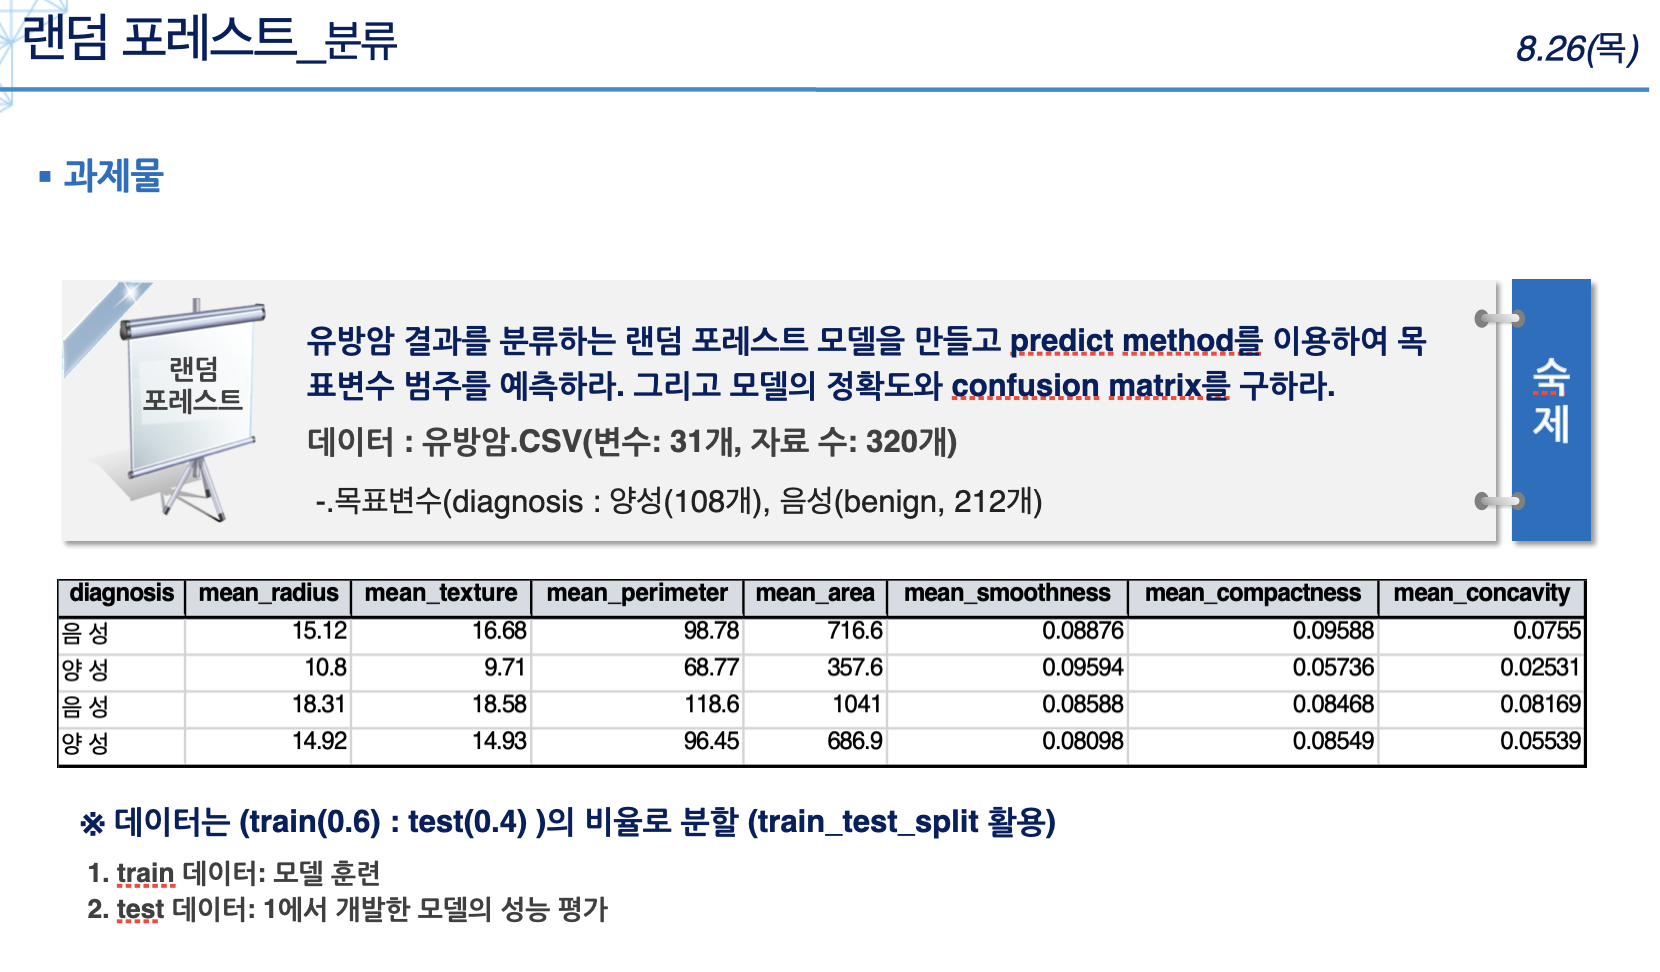

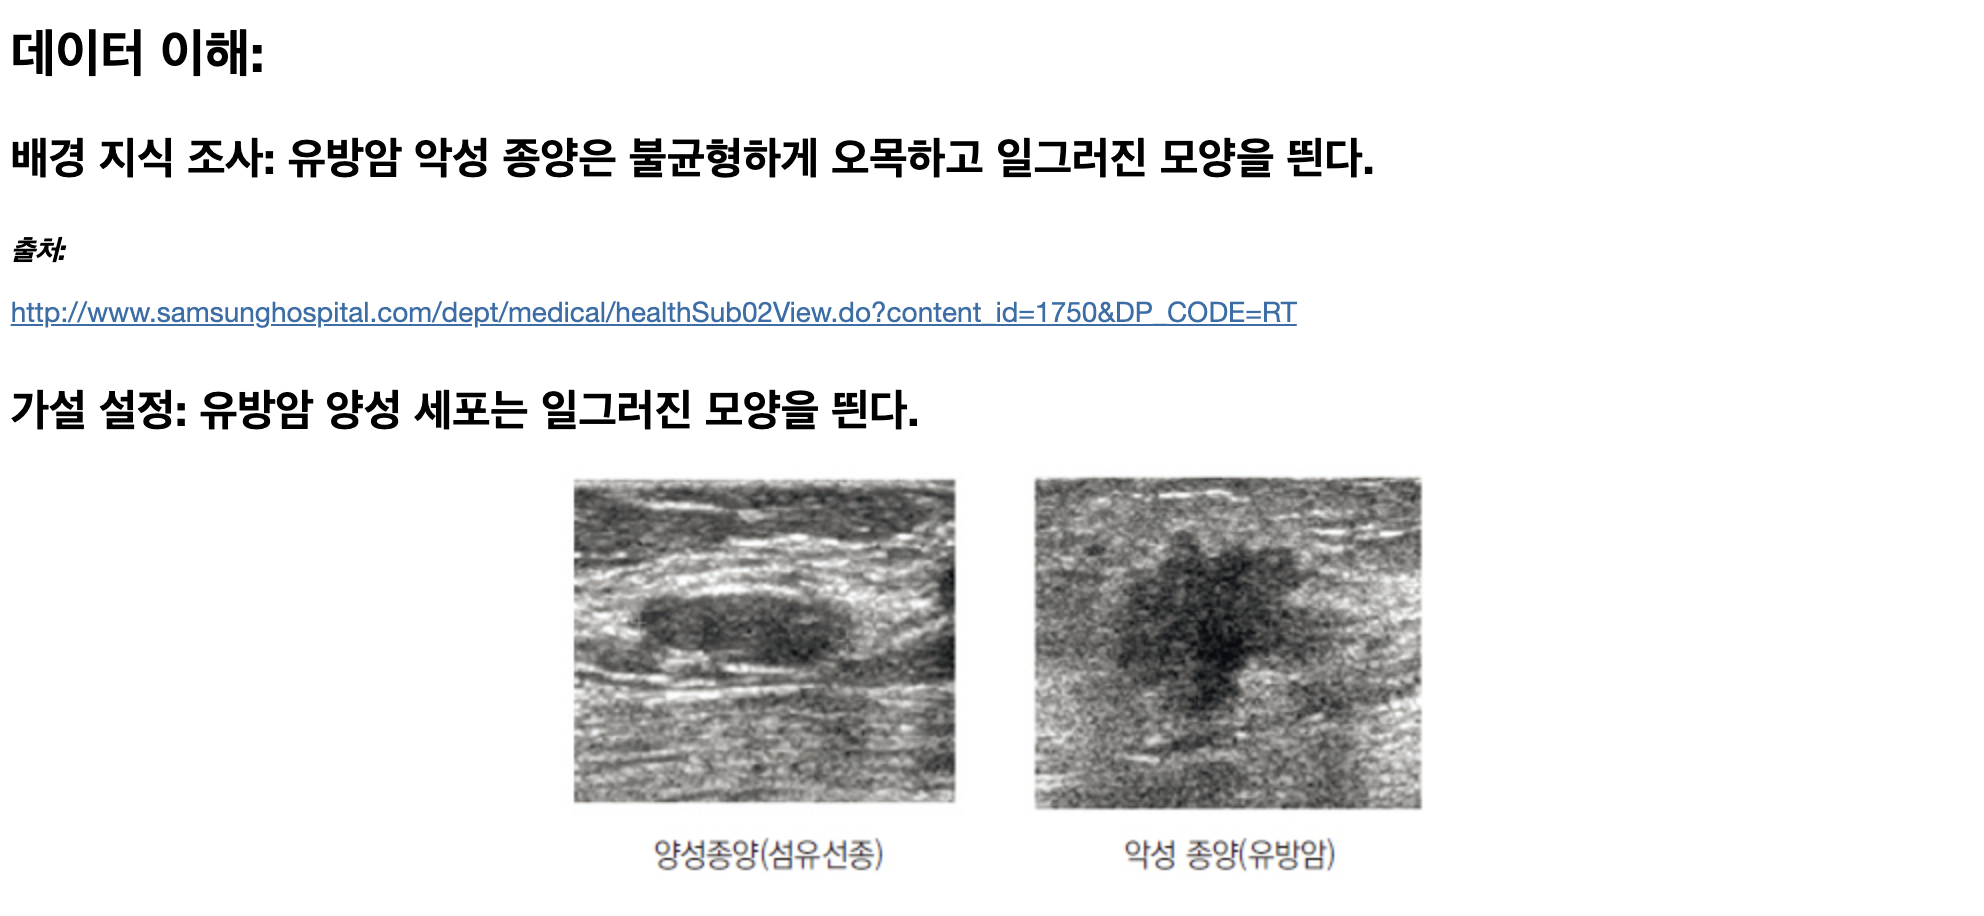

In [50]:
## 데이터 구성하기
df_raw = pd.read_csv('유방암.csv', engine='python', encoding='cp949')
df_raw.head(n=3)

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,음성,15.12,16.68,98.78,716.6,0.08876,0.09588,0.07550,0.04079,0.1594,...,17.77,20.24,117.70,989.5,0.1491,0.3331,0.3327,0.12520,0.3415,0.09740
1,양성,10.80,9.71,68.77,357.6,0.09594,0.05736,0.02531,0.01698,0.1381,...,11.60,12.02,73.66,414.0,0.1436,0.1257,0.1047,0.04603,0.2090,0.07699
2,음성,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,...,21.31,26.36,139.20,1410.0,0.1234,0.2445,0.3538,0.15710,0.3206,0.06938


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                320 non-null    object 
 1   mean_radius              320 non-null    float64
 2   mean_texture             320 non-null    float64
 3   mean_perimeter           320 non-null    float64
 4   mean_area                320 non-null    float64
 5   mean_smoothness          320 non-null    float64
 6   mean_compactness         320 non-null    float64
 7   mean_concavity           320 non-null    float64
 8   mean_concave_points      320 non-null    float64
 9   mean_symmetry            320 non-null    float64
 10  mean_fractal_dimension   320 non-null    float64
 11  radius_error             320 non-null    float64
 12  texture_error            320 non-null    float64
 13  perimeter_error          320 non-null    float64
 14  area_error               3

## 결측치 확인


In [4]:
df_raw.isnull().sum()

diagnosis                  0
mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave_points        0
mean_symmetry              0
mean_fractal_dimension     0
radius_error               0
texture_error              0
perimeter_error            0
area_error                 0
smoothness_error           0
compactness_error          0
concavity_error            0
concave_points_error       0
symmetry_error             0
fractal_dimension_error    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave_points       0
worst_symmetry             0
worst_fractal_dimension    0
dtype: int64

## 데이터 변환: 목표 변수인 유방암 진단결과를 0(음성),1(양성)로 변환

In [5]:
df_raw.replace({'diagnosis': '양성'}, 1, inplace=True)
df_raw.replace({'diagnosis': '음성'}, 0, inplace=True)

In [6]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw.drop("diagnosis",axis=1),df_raw["diagnosis"], test_size = 0.3, random_state=1234)
print('train x data size : {}'.format(df_train_x.shape))
print('train y data size : {}'.format(df_train_y.shape))
print('test x data size : {}'.format(df_test_x.shape))
print('test y data size : {}'.format(df_test_y.shape))

train x data size : (224, 30)
train y data size : (224,)
test x data size : (96, 30)
test y data size : (96,)


# 랜덤 포레스트

# 기본 옵션으로 모델 생성
train 데이터로 학습한 모델의 정확도가 100%으로 train 데이터에 과적합 되어있는 것으로 해석된다.

따라서 파라메터를 최적화할 필요성이 있다.

In [7]:
rf_uncustomized =RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x,df_train_y)
print("Accuracy in train set:{:.3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))
print("Accuracy in test set:{:.3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))

Accuracy in train set:1.000
Accuracy in test set:0.927


# 모델 파라메터 조정 0: 트리개수 =>20선택

- 선택 이유
default값에 따르면 변수개수의 제곱근인 np.sqrt(30)=5.5->6개가 선택된다.

하지만 트리 개수가 6개 인 경우 train, test 간 정확도 차이가 크며, 정확도가 낮다.

따라사 정확도가 증가된 트리 개수 20을 선택하였다.


train 정확도가 높고 일정하게 유지되는 구간에서, test 정확도가 높아지는 지점이므로
두 정확도 간 차이가 줄어들기 때문에 선택했습니다.


In [14]:
train_accuracy = []; test_accuracy =[]
para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    tree = RandomForestClassifier(n_estimators=v_n_estimators,random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimator"] = para_n_tree
df_accuracy_n["TrainAccuracy"]=train_accuracy
df_accuracy_n["TestAccuracy"]=test_accuracy

In [15]:
df_accuracy_n.round(3)

,n_estimator,TrainAccuracy,TestAccuracy
0,10,0.991,0.865
1,20,1.000,0.917
2,30,1.000,0.927
3,40,1.000,0.927
4,50,1.000,0.927
5,60,1.000,0.927
6,70,1.000,0.927
7,80,1.000,0.927
8,90,1.000,0.938
9,100,1.000,0.927


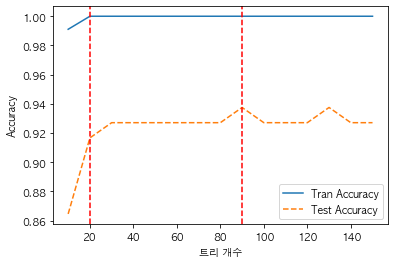

In [21]:
plt.plot(para_n_tree,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_n_tree,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('트리 개수')
plt.axvline(x=20, linestyle='--', c='r')
plt.axvline(x=90, linestyle='--', c='r')

plt.legend()

In [25]:
# oob_error =[]
# for v_n_estimator in range(1,100):
#     rf = RandomForestClassifier(n_estimators=v_n_estimator,oob_score=True,random_state=1234)
#     rf.fit(df_train_x,df_train_y)
#     oob_error.append(1-rf.oob_score_)    

/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do 

In [51]:
#plt.plot(range(1,151),oob_error)
#plt.ylabel("oob error")
#plt.xlabel("n_estimators")

# 모델 파라메터 조정 1: max_depth 최대 깊이 =>5선택
- 선택 이유

train, test 값의 차이가 작은 지점인 5를 선택했습니다.

In [26]:
train_accuracy = []; test_accuracy =[]
para_depth = [depth for depth in range(1,11)]

for v_min_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_min_max_depth,n_estimators=20 ,random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"]=train_accuracy
df_accuracy_depth["TestAccuracy"]=test_accuracy
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.964,0.896
1,2,0.978,0.885
2,3,0.987,0.896
3,4,1.000,0.896
4,5,1.000,0.917
5,6,1.000,0.917
6,7,1.000,0.917
7,8,1.000,0.917
8,9,1.000,0.917
9,10,1.000,0.917


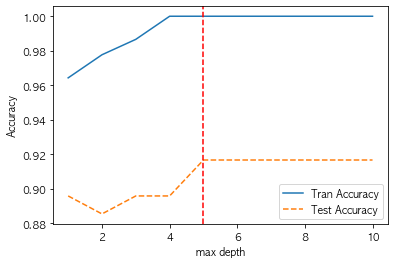

In [28]:
plt.plot(para_depth,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_depth,test_accuracy,linestyle='--',label="Test Accuracy")
plt.xlabel("max depth");plt.ylabel("Accuracy")
plt.axvline(x=5, linestyle='--', c='r')

plt.legend()

# 모델 파라메터 조정 2: 분리 노드의 최소 자료 수 =>10선택
분리 노드의 최소 자료 수가 증가할수록 정확도가 감소하므로

train, test accuracy 가 높은 10을 선택

In [29]:
train_accuracy = []; test_accuracy =[]
para_split = [n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split=v_min_samples_split,max_depth = 5,n_estimators=20 ,random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"]=train_accuracy
df_accuracy_split["TestAccuracy"]=test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.987,0.938
1,20,0.982,0.906
2,30,0.982,0.896
3,40,0.982,0.896
4,50,0.978,0.896
5,60,0.964,0.854
6,70,0.969,0.854
7,80,0.964,0.865
8,90,0.964,0.896
9,100,0.964,0.896


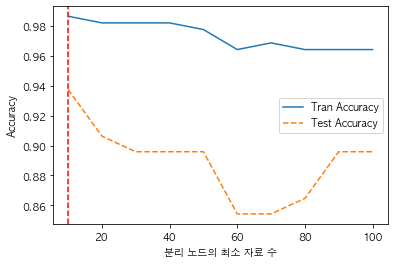

In [33]:
plt.plot(para_split,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_split,test_accuracy,linestyle='--',label="Test Accuracy")
plt.xlabel("분리 노드의 최소 자료 수");plt.ylabel("Accuracy")
plt.axvline(x=10, linestyle='--', c='r')
plt.legend()

# 모델 파라메터 조정 3:  잎사귀 노드의 최소 자료 수 =>30선택
잎사귀 노드의 최소 자료 수가 증가할수록 정확도가 감소하므로

가능한 작은 개수 중에서 train, test accuracy차이가 작은 30을 선택하였다.


In [36]:
train_accuracy = []; test_accuracy =[]
para_leaf = [n_leaf*10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf = v_min_samples_leaf,min_samples_split=10,max_depth = 4,n_estimators=20 ,random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesleaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"]=train_accuracy
df_accuracy_leaf["TestAccuracy"]=test_accuracy
df_accuracy_leaf.round(3)

,MinSamplesleaf,TrainAccuracy,TestAccuracy
0,10,0.973,0.896
1,20,0.973,0.906
2,30,0.969,0.906
3,40,0.964,0.875
4,50,0.969,0.885
5,60,0.969,0.885
6,70,0.955,0.885
7,80,0.625,0.750
8,90,0.625,0.750
9,100,0.625,0.750


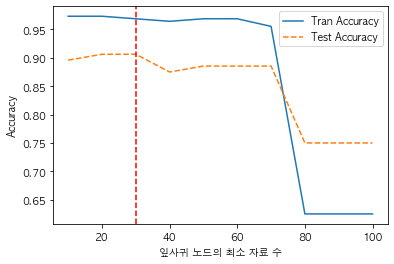

In [51]:
plt.plot(para_leaf,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_leaf,test_accuracy,linestyle='--',label="Test Accuracy")
plt.axvline(x=30, linestyle='--', c='r')
plt.xlabel("잎사귀 노드의 최소 자료 수");plt.ylabel("Accuracy")
plt.legend()

# 최종 모델:

## 하이퍼 파라메터: 
n_tree =20, max_depth=5,min_samples_split=10,min_samples_leaf=30


In [52]:
rf_final = RandomForestClassifier(min_samples_leaf=30,min_samples_split=10,max_depth=4,n_estimators=100, random_state=1234)
rf_final.fit(df_train_x,df_train_y)
y_pred = rf_final.predict(df_test_x)

# 최종 모델 평가

## 📌해석
#### **Decision Tree 20개 모델의 평균을 낸 정확도(정분류율)는 95.5%으로 단일 Tree 모델의 결과인 90.6%보다 정확도가 상승하였다.**

의학 분야이다보니 더 높은 정확도가 필요할 수 있다.

목표 변수 1기준 f1-score은 0.833이다.

In [43]:
print("Accuracy on training set:{:.3f}".format(rf_final.score(df_train_x,df_train_y)))
print("Accuracy on test set:{:.3f}".format(rf_final.score(df_test_x,df_test_y)))
print("\nAccuracy on test set\n:{}".format(confusion_matrix(df_test_y,y_pred)))

print(classification_report(df_test_y,y_pred,digits=3))

Accuracy on training set:0.955
Accuracy on test set:0.917

Accuracy on test set
:[[68  4]
 [ 4 20]]
              precision    recall  f1-score   support

           0      0.944     0.944     0.944        72
           1      0.833     0.833     0.833        24

    accuracy                          0.917        96
   macro avg      0.889     0.889     0.889        96
weighted avg      0.917     0.917     0.917        96



# 설명 변수의 중요도
## 📌해석: 단일 Tree 모델의 결과와 비교

### 어떤 설명 변수가 유방암 진단에 가장 큰 영향을 미치는가?

1.  RandomForest 결과 설명변수 중요도가 모두 16%이하로 작은 값을 가진다.

    이는 단일 Tree 유방암 양성 진단에 세포의 평균 오목한 점의 수(mean concave points)의 상대적 중요도가 77.2%로 매우 높았던 것과 상반된 결과이다.

    이를 통해 RandomForest는 데이터와 변수를 복원추출하기 때문에 단일 Tree모델보다 안정적이다. 
    
    따라서 유방암 양성 진단에

    worst_perimeter, 	
    mean_concave_points, 	
    mean_concavity, 	
    worst_concave_points,	
    worst_radius,
    worst_area,
    mean_perimeter,	
    worst_concavity,	
    mean_area,	
    mean_radius 
    변수들이 비슷한 영향력을 끼치는 것으로 해석된다.


2. error변수들은 단일 Tree 결과와 마찬가지로 상대적 중요도가 거의 0에 수렴한다.
    이는 변수들의 측정 오차이므로 중요도가 작아야하는 당연히 예상 가능한 결과이다.
    


In [45]:
v_feature_name=df_train_x.columns
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=rf_final.feature_importances_

df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance.round(3)


,Feature,Importance
22,worst_perimeter,0.160
7,mean_concave_points,0.157
6,mean_concavity,0.134
27,worst_concave_points,0.112
20,worst_radius,0.092
23,worst_area,0.078
2,mean_perimeter,0.054
26,worst_concavity,0.053
3,mean_area,0.041
0,mean_radius,0.032


Text(0, 0.5, '설명변수')

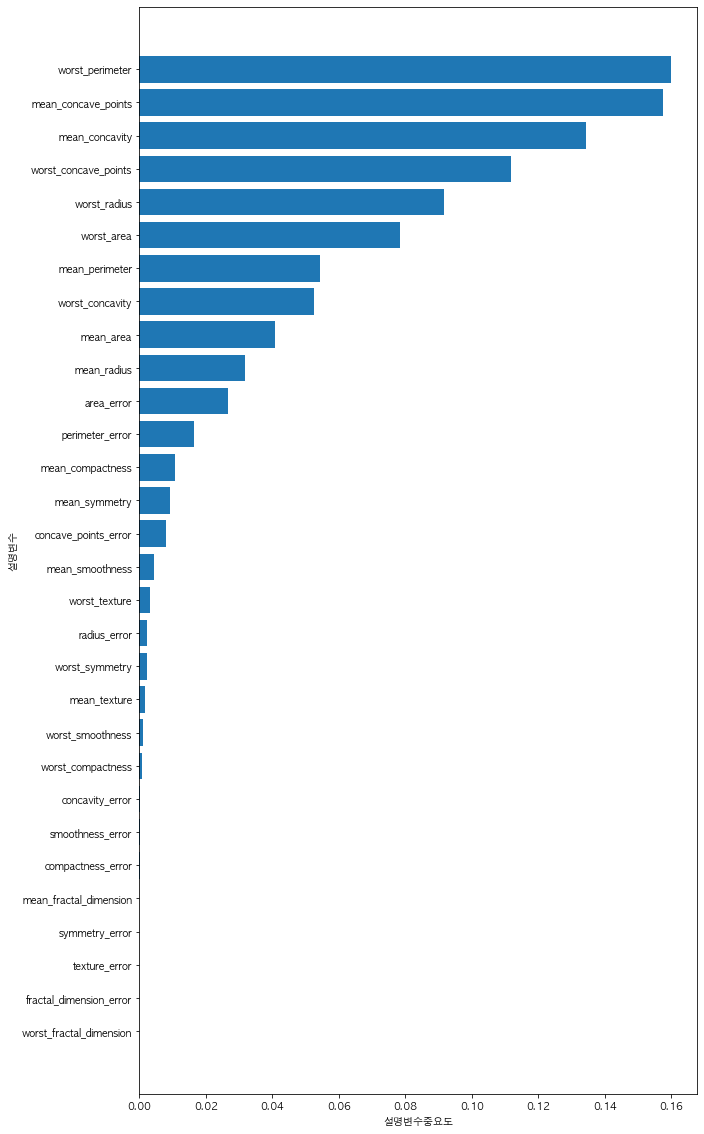

In [48]:
df_importance.sort_values("Importance",ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))
plt.barh(y=coordinates,width=df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("설명변수중요도")
plt.ylabel("설명변수")